# Pregunta 4

### Funciones de activación

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    x = np.clip( x, -200, 200 )
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)

def softmax_prime(signal):
    return softmax(signal) * (1 - softmax(signal))
    

def sigmoid(x):
    x = np.clip( x, -20, 20 )
    return 1 / (1+np.exp(-x))

def sigmoid_prime(x):
    x = np.clip( x, -20, 20 )
    upper = np.exp(-x)
    lower = ((1 + np.exp(-x))**2)
    return upper / lower

def relu(x):
    # x = np.clip( x, -10, 10 )
    x = np.clip( x, -20, 20 )
    return np.abs(x) * (x > 0)

def relu_prime(x):
    # x = np.clip( x, -10, 10 )
    x = np.clip( x, -20, 20 )
    return np.where(x > 0, 1.0, 0.0)

def linear(x):
    return x

### Dataset

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, load_breast_cancer
X_train,y_train = load_iris(return_X_y=True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Convert the targets to one hot vectors
import keras
y_onehot = keras.utils.to_categorical(y_train)

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Red Feed-forward con momentum

1) $\delta^L = \nabla _a C \odot \sigma ' (z^L)$, con $\nabla_ a C = a^L - y$, donde se puede interpretar a $a^L$ como $\hat{y}$

2) $\delta^l = ((w^{(l + 1)})^T \delta^{(l+1)}) \odot \sigma ' (z^l)$

3) $\frac{\partial C}{\partial b^l_j} = \delta^l_ j$

4) $\frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k \delta^l_j$

[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 0, 2, 2, 1, 0, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 1, 2, 0, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 2, 1, 0, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 2, 2, 1, 2, 0, 1]
Tests passed with a score of:  0.6


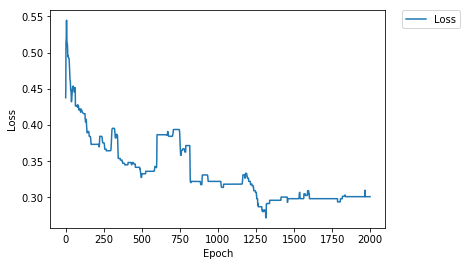

In [7]:
import numpy as np
import warnings
from random import randint, random, seed, uniform, shuffle
import keras
from sklearn.metrics import accuracy_score

warnings.filterwarnings("error")
    
class Network:
    # The layers variable receives a specification with the following format:
    # [
    #    "neurons": n_neurones,
    #    "activation": "activation_function",
    # ]
    
    activation_function_hash = {
        "softmax": {
            "func": softmax,
            "func_prime": softmax_prime,
        },
        "sigmoid": {
            "func": sigmoid,
            "func_prime": sigmoid_prime,
        },
        
        "relu": {
            "func": relu,
            "func_prime": relu_prime,
        },
        
        "linear": {
            "func": linear,
            "func_prime": 1,
        }
    }
    
    # loss defines the method to calculate cost
    # crossentropy or mse
    def __init__(self, layers, loss="mse", friction = 1.0, verbose = False):
        self.layers = layers
        self.loss = loss
        self.loss_history = []
        self.mu = friction
        self.verbose = verbose
        
        # The first layer is the input layer, and does not have biases
        # or weights
        self.biases = np.array([np.random.randn(l["neurons"], 1) for l in layers[1:]])
        
        # The amount of weights depensd on both the amount of neurones on the layer 
        # and the dimension of the inputs.
        self.weights = np.array([np.random.randn(curr_l["neurons"], prev_l["neurons"]) for prev_l, curr_l in zip(layers[:-1], layers[1:])])
        self.velocities = np.array([np.random.randn(curr_l["neurons"], prev_l["neurons"]) for prev_l, curr_l in zip(layers[:-1], layers[1:])])
        
        # self.biases = np.array([np.zeros((l["neurons"], 1)) for l in layers[1:]])
        # self.weights = np.array([np.zeros((curr_l["neurons"], prev_l["neurons"])) for prev_l, curr_l in zip(layers[:-1], layers[1:])])
        
    # Returns final output, activation output at each layer
    # and z value at each layer
    def forward_propagation(self, data):
        output = data
        activations = [data]
        zs = []
        
        # We start on the first layer. Note that the input layer
        # is pretty much ignored as it does not have activation
        # functions or anything like that.
        
        # First layer is ignored as it only provides dimension of the inputs
        for B, W, layer, index in zip(self.biases, self.weights, self.layers[1:], range(0, len(self.biases))):
            
            # Calculate the Z output. B corresponds to the biases of this layer.
            dot = np.dot(W, output)
            dot = dot.reshape(len(dot), 1)
            Z = dot + B

            # Save it for future usage
            zs.append(Z)
            
            # Get the activation function based on the configuratiomn that was given at the construction
            # of this network.
            activation_string = layer["activation"]
            g = Network.activation_function_hash[activation_string]["func"]
            
            # Get the output of the activation function and store it
            output = g(Z)
            activations.append(output)

        # Return a list with all activations an Z values that represent all layers
        return activations, zs    
    
    
    # Devuelve el output de la red
    def evaluate(self, X):
        output = []
        for x in X:
            (acts, zs) = self.forward_propagation(x)
            output.append(acts[-1])
            
        return np.array(output)
    
    def classify(self, x):
        return np.argmax(x)
        
        
        
    
    # Receives a single sample X with its 
    # corresponding value Y and returns the 
    # derivatives for the weights and biases
    # We want to get dc/db and dc/dw
    
    def get_total_cost(self, X, Y):
        
        n = self.layers[-1]["neurons"]
        
        cost = 0.0
        A = self.evaluate(X)
        
        
        if self.loss == "mse":
            for a, y in zip(A, Y):
                cost += 0.5*np.linalg.norm((a.reshape(n, 1) - np.array(y).reshape(n, 1)))**2 / len(A)
        elif self.loss == "crossentropy":
            for a, y in zip(A, Y):
                a = a.reshape(n, 1)
                y = np.array(y.reshape(n, 1))
                
                E = 0.0
            
                cost += np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
        return cost

    
    def cost_derivative(self, a, y):
        if self.loss == "mse":
            return (a - y)
        return None

    def get_delta(self, a, z, y, activation_derivative):
        # Equation 1 says how this should got, at least for mse
        if self.loss == "mse":
            return (a - y) * activation_derivative(z)
        elif self.loss == "crossentropy":
            return (a - y)
        
        return None
    
    def backprop(self, x, y_true):
        # This stores the gradien of each weight and bias. The idea is to calculate
        gradient_b = np.array([np.zeros(bias.shape) for bias in self.biases])
        gradient_w = np.array([np.zeros(weight.shape) for weight in self.weights])
        
        # Propagate the input through the network and get all the
        # z outputs and activation outputs of all layers
        # The first activation corresponds to the first input layer
        (acts, zs)  = self.forward_propagation(x)
        
        # Use the specified activation function's derivative
        g_prime = Network.activation_function_hash[self.layers[-1]["activation"]]["func_prime"]
        
        
        
        # We first calculate the delta value of the output layer, given as
        # delta_cost = aL - y
        # [ , , , , X] (= -1)
        # [ , , , X, ] ( = -2)
        # ....
        # [X, , , , ,] ( = -L)
        n = self.layers[-1]["neurons"]
        
        # We reshape to get the vectors of the output values
        # An example would be like this
        # z = [[ giberish ],
        #      [ giberish ],
        #      [ giberish ]]
        # 
        # a = [[ 0.87349 ],
        #      [ 0.22223 ],
        #      [ 0.01344 ]]
        # 
        # y = [[ 1 ],
        #      [ 0 ],
        #      [ 0 ]]
        # 
        # Supposedly, the vector a should have norm 1 as we will always use sigmoid
        a = acts[-1].reshape(n, 1)
        z = zs[-1].reshape(n, 1)
        y = y_true.reshape(n, 1)

        delta = self.get_delta(a, z, y, g_prime)

        # Gradient B = delta
        gradient_b[-1] = delta
        
        # Gradient W = delta x A(L - 1)T
        gradient_w[-1] = np.dot(delta, acts[-2].T)

        # We now have the L layer with its deltas and gradients calculated.
        # Now we iterate over each layer to propagate the gradients "recursively"
        for layer in range(2, len(self.layers)):
            
            # Use the specified activation function's derivative
            z = zs[-layer]
            
            g_prime = Network.activation_function_hash[self.layers[-layer]["activation"]]["func_prime"]
            delta = np.dot(self.weights[-layer + 1].T, delta) * g_prime(z)
            
            gradient_b[-layer] = delta
            
            # If on first layer, we reshape the input data
            if (layer == len(self.layers) - 1):
                
                dim = len(acts[-layer - 1])
                
                gradient_w[-layer] = np.dot(delta, np.array(acts[-layer - 1]).reshape(dim, 1).T)
            else:
                gradient_w[-layer] = np.dot(delta, acts[-layer - 1].T)
            
        return (gradient_b, gradient_w)
            
    def get_costs(self):
        return self.loss_history
    
    def SGD(self, trainX, trainY, epochs, lr):
        for e in range(0, epochs):
            nabla_b = [np.zeros(b.shape) for b in self.biases]
            nabla_w = [np.zeros(w.shape) for w in self.weights]
            for x, y in zip(trainX, trainY):
                delta_nabla_b, delta_nabla_w = self.backprop(x, y)
                nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
                nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
                
                
            self.velocities = [self.mu*v-(lr/len(trainX))*nw
                            for v, nw in zip(self.velocities, nabla_w)]
            self.weights = [w + v
                            for w, v in zip(self.weights, self.velocities)]
            self.biases = [b-(lr/len(trainX))*nb
                           for b, nb in zip(self.biases, nabla_b)]
            
            cost = self.get_total_cost(trainX, trainY)
            if self.verbose:
                print("Epoch ", e + 1, "/", epochs, ":", cost)
            self.loss_history.append(cost)
                
    
# The network should have 2 layers, the first with 32 neurons and the second with 16
# You basically will have an architecture like this:
# input -> layer 1 (32) -> later 2 (16) -> output (3 neurons with softmax activation function)

"""
Bellow here we test our implementation
"""
import keras
T = 100
M = 5
dataX = np.array([np.random.randn(M, 1) for n in range(0, T)])
dataY = [randint(0,2) for n in range(0, T)]
dataYOnehot = keras.utils.to_categorical(dataY)
network = Network([{
    "neurons": len(X_train[0]),
    "activation": "linear"
}, {
    "neurons": 32,
    "activation": "sigmoid"
}, {
    "neurons": 16,
    "activation": "sigmoid"
}, {
    "neurons": 3,
    "activation": "softmax"
}], loss="mse", friction=1.0, verbose=False)

x = dataX[0]
y = dataY[0]


network.SGD(X_train, y_onehot, 2000, 0.1)
yHat = np.array(network.evaluate(X_train))

yHatHot = []

for yi in yHat:
    yHatHot.append(network.classify(yi))

# Measure classification accuracy
from sklearn.metrics import accuracy_score

print(yHatHot)
print("Tests passed with a score of: ", accuracy_score(y_train, yHatHot))


# Graph the loss function 
import matplotlib.pyplot as plt


costs = network.get_costs()

plt.plot(range(0, len(costs)), costs, label="Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.show()




No hay una mejora significativa en el tiempo de ejecución del algoritmo, ni en la calidad de la solución a la que converge. Teóricamente, la utilización de momentum debería acelerar la convergencia en comparación a Gradient Descent normal. Se puede explicar la falta de mejora por las restricciones impuestas a las funciones de activación para evitar el overflow numérico. El mejor accuracy obtendio con 2000 epochs y sigmoid corresponde a 0.6